In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Overall Settings
FINE_TUNING_EPOCHS = 5
TRAINING_EPOCHS = 3
BATCH_SIZE = 32

image_height = 299
image_width = 299

In [13]:
# Deep learning libraries
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [14]:
# Data augmentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale = 1./255,
                         zoom_range = 0.05,
                         width_shift_range = 0.05,
                         height_shift_range = 0.05,
                         brightness_range = [0.95,1.05])
 
train_generator = gen.flow_from_directory(
    directory = "./data/chest-xray/train",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 5216 images belonging to 2 classes.


In [15]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_directory(
    directory   = "./data/chest-xray/val",
    color_mode  = "rgb",
    target_size = (image_height, image_width),
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_directory(
    directory   = "./data/chest-xray/test",
    color_mode  = "rgb",
    target_size = (image_height, image_width),
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
print(class_names)

['NORMAL', 'PNEUMONIA']


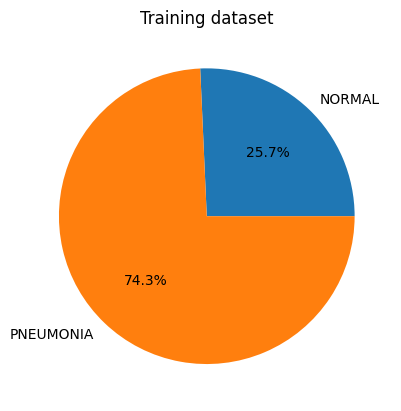

In [17]:
freq = np.unique(train_generator.classes, return_counts=True)

plt.title("Training dataset")
plt.pie(freq[1], labels = class_names, autopct='%1.1f%%');

In [19]:
# clearly an unbalanced data set so let's some class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))

print(class_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [21]:
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])])

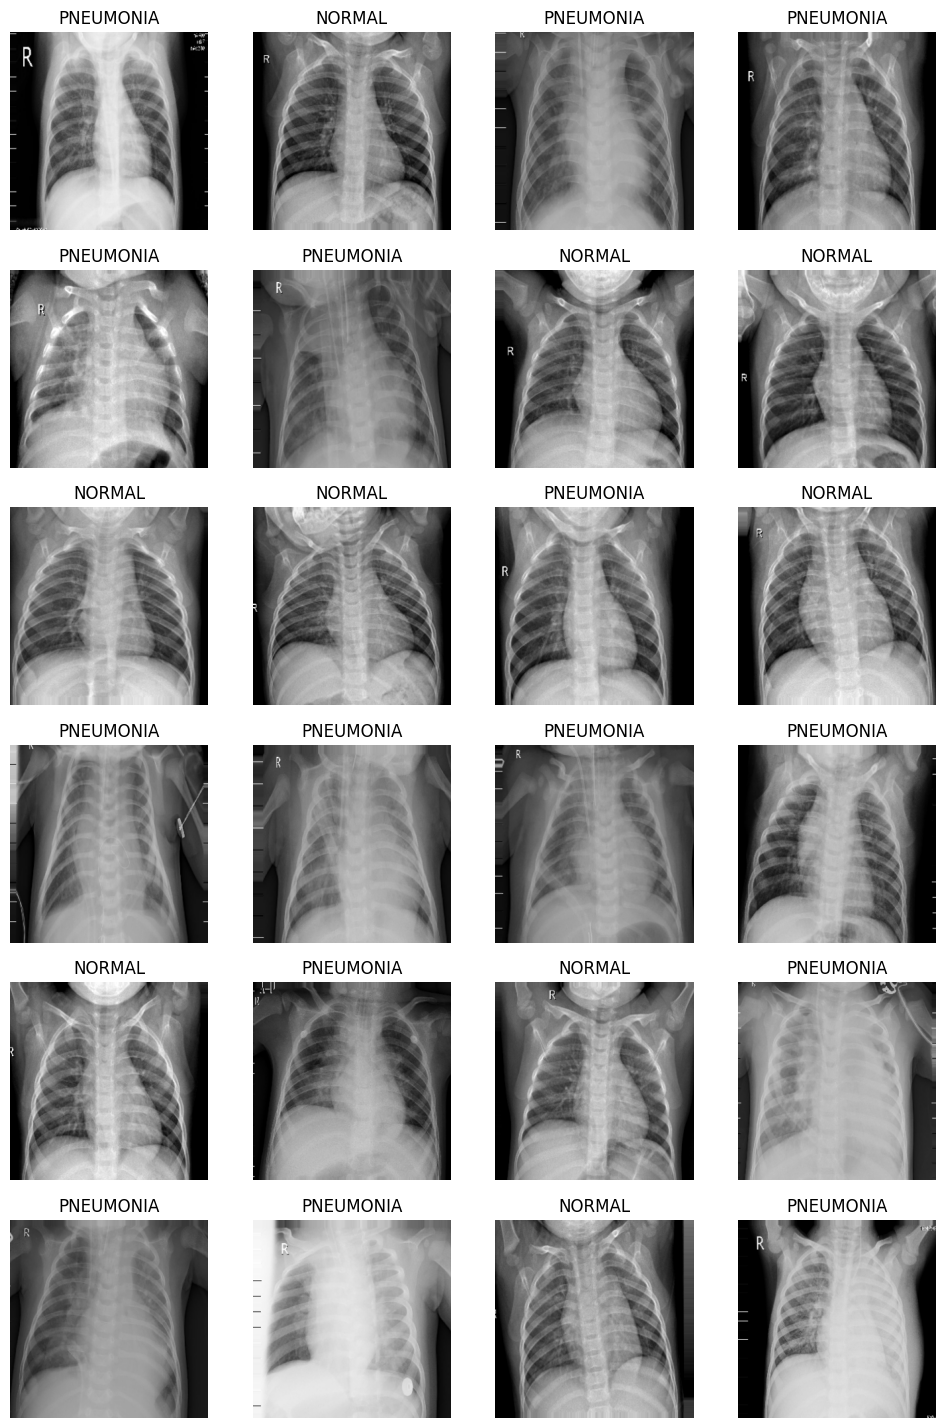

In [22]:
x,y = next(train_generator)
plot_images(x,y)

In [23]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    new_title = f'{title}\n Sensitivity = {sensitivity:.2f} Specificity = {specificity:.2f}'
    
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    
    ax.set_title(new_title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

In [25]:
from matplotlib import cm

def make_gradcam_heatmap(image, model, last_conv_layer_name):
 
    img_array = tf.expand_dims(image, axis=0)
    
    # Remove last layer's softmax
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()  
    
    
     # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255 

    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    # Restore last layer activation
    model.layers[-1].activation = last_layer_activation
    
    return superimposed_img

In [26]:
from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [27]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       
    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early],
                        class_weight=class_weights)
    
    return history

In [28]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)
#inception_model.summary()
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/3


C:\Users\sujal\pulmo-ai\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 10/163 ━━━━━━━━━━━━━━━━━━━━ 19:21 8s/step - accuracy: 0.5534 - loss: 0.7371

KeyboardInterrupt: 